# BottomUpParceLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)

['1.19.2', '1.1.2', '0.14.1', '1.5.0']


## Test data
First, we generate a causal structure with 7 variables. Then we create a dataset with 6 variables from x0 to x5, with x6 being the latent variable for x2 and x3.

In [2]:
np.random.seed(1000)

x6 = np.random.uniform(size=1000)
x3 = 2.0*x6 + np.random.uniform(size=1000)
x0 = 0.5*x3 + np.random.uniform(size=1000)
x2 = 2.0*x6 + np.random.uniform(size=1000)
x1 = 0.5*x0 + 0.5*x2 + np.random.uniform(size=1000)
x5 = 0.5*x0 + np.random.uniform(size=1000)
x4 = 0.5*x0 - 0.5*x2 + np.random.uniform(size=1000)

# The latent variable x6 is not included.
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T, columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

X.head()

,x0,x1,x2,x3,x4,x5
0,1.505949,2.667827,2.029420,1.463708,0.615387,1.157907
1,1.379130,1.721744,0.965613,0.801952,0.919654,0.957148
2,1.436825,2.845166,2.773506,2.533417,-0.616746,0.903326
3,1.562885,2.205270,1.080121,1.192257,1.240595,1.411295
4,1.940721,2.974182,2.140298,1.886342,0.451992,1.770786


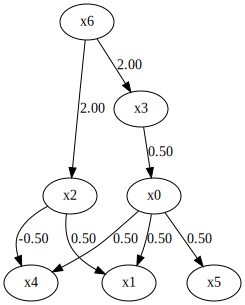

In [3]:
m = np.array([[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.5, 0.0,-0.5, 0.0, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

dot = make_dot(m)

# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Causal Discovery
To run causal discovery, we create a `BottomUpParceLiNGAM` object and call the `fit` method.

In [4]:
model = lingam.BottomUpParceLiNGAM()
model.fit(X)

Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery. x2 and x3, which have latent confounders as parents, are stored in a list without causal ordering.

In [5]:
model.causal_order_

[[2, 3], 0, 5, 1, 4]

Also, using the `adjacency_matrix_` properties, we can see the adjacency matrix as a result of the causal discovery. The coefficients between variables with latent confounders are np.nan.

In [6]:
model.adjacency_matrix_

array([[ 0.   ,  0.   ,  0.   ,  0.506,  0.   ,  0.   ],
       [ 0.499,  0.   ,  0.495,  0.007,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,    nan,  0.   ,  0.   ],
       [ 0.   ,  0.   ,    nan,  0.   ,  0.   ,  0.   ],
       [ 0.448,  0.   , -0.451,  0.   ,  0.   ,  0.   ],
       [ 0.48 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

We can draw a causal graph by utility funciton.

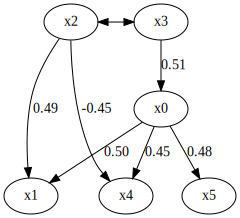

In [7]:
make_dot(model.adjacency_matrix_)

## Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [8]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

model = lingam.BottomUpParceLiNGAM()
result = model.bootstrap(X, n_sampling=100)

## Causal Directions
Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [9]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [10]:
print_causal_directions(cdc, 100)

x4 <--- x0 (b>0) (45.0%)
x4 <--- x2 (b<0) (45.0%)
x1 <--- x0 (b>0) (41.0%)
x1 <--- x2 (b>0) (41.0%)
x5 <--- x0 (b>0) (26.0%)
x1 <--- x3 (b>0) (21.0%)
x0 <--- x3 (b>0) (12.0%)
x5 <--- x2 (b>0) (7.0%)


## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [11]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [12]:
print_dagc(dagc, 100)

DAG[0]: 33.0%
DAG[1]: 13.0%
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
DAG[2]: 7.0%
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)


## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [13]:
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

[[0.   0.01 0.   0.12 0.01 0.  ]
 [0.41 0.   0.41 0.21 0.   0.  ]
 [0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.45 0.03 0.45 0.02 0.   0.07]
 [0.26 0.01 0.07 0.02 0.   0.  ]]


## Causal Effects
Using the `get_causal_effects()` method, we can get the list of causal effect. The causal effects we can get are dictionary type variable.
We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [14]:
causal_effects = result.get_causal_effects(min_causal_effect=0.01)

# Assign to pandas.DataFrame for pretty display
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x1,x4,0.045256,0.14
1,x0,x5,0.517290,0.12
2,x0,x1,0.477885,0.11
3,x4,x1,0.044782,0.11
4,x0,x4,0.494946,0.11
5,x5,x1,0.025297,0.06
6,x5,x4,-0.031346,0.06
7,x2,x1,0.482657,0.02
8,x2,x4,-0.490889,0.02
9,x3,x0,0.511008,0.01


We can easily perform sorting operations with pandas.DataFrame.

In [15]:
df.sort_values('effect', ascending=False).head()

,from,to,effect,probability
12,x3,x2,0.790837,0.01
10,x3,x1,0.653876,0.01
1,x0,x5,0.517290,0.12
9,x3,x0,0.511008,0.01
4,x0,x4,0.494946,0.11


In [16]:
df.sort_values('probability', ascending=True).head()

,from,to,effect,probability
9,x3,x0,0.511008,0.01
10,x3,x1,0.653876,0.01
11,x0,x2,-0.044259,0.01
12,x3,x2,0.790837,0.01
13,x5,x2,0.054423,0.01


And with pandas.DataFrame, we can easily filter by keywords. The following code extracts the causal direction towards x1.

In [17]:
df[df['to']=='x1'].head()

,from,to,effect,probability
2,x0,x1,0.477885,0.11
3,x4,x1,0.044782,0.11
5,x5,x1,0.025297,0.06
7,x2,x1,0.482657,0.02
10,x3,x1,0.653876,0.01


Because it holds the raw data of the causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

(array([88.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.   , 0.051, 0.102, 0.153, 0.204, 0.256, 0.307, 0.358, 0.409,
        0.46 , 0.511]),
 <BarContainer object of 10 artists>)

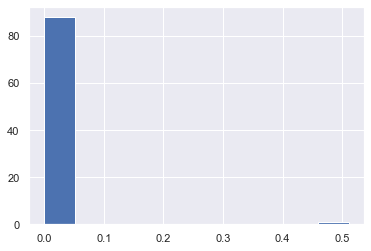

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 3 # index of x3
to_index = 0 # index of x0
plt.hist(result.total_effects_[:, to_index, from_index])